In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

## AR(p) Models and Stationarity

Consider fitting AR($p$) models starting with $p = 1$ to the following GNP dataset (from https://fred.stlouisfed.org/series/GNP). This is quarterly data. 

  observation_date      GNP
0       1947-01-01  244.142
1       1947-04-01  247.063
2       1947-07-01  250.716
3       1947-10-01  260.981
4       1948-01-01  267.133


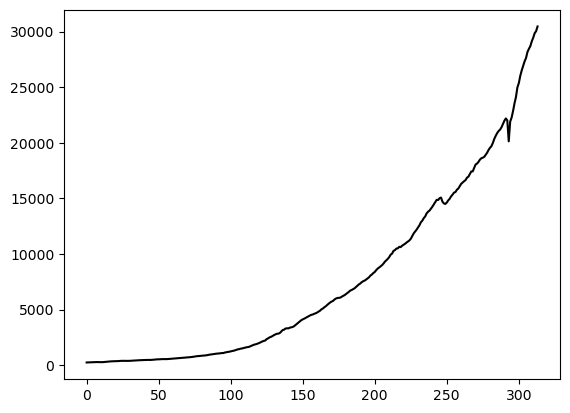

In [2]:
gnp = pd.read_csv("GNP_30Oct2025.csv")
print(gnp.head())
y = gnp['GNP'].to_numpy()
plt.plot(y, color = 'black')
plt.show()

As usual, we fit AR($p$) models using the AutoReg function. 

In [3]:
armd = AutoReg(y, lags = 1).fit()
print(armd.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  314
Model:                     AutoReg(1)   Log Likelihood               -2054.516
Method:               Conditional MLE   S.D. of innovations            171.573
Date:                Fri, 07 Nov 2025   AIC                           4115.031
Time:                        14:45:08   BIC                           4126.270
Sample:                             1   HQIC                          4119.523
                                  314                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8687     13.423      0.661      0.509     -17.439      35.176
y.L1           1.0116      0.001    827.008      0.000       1.009       1.014
                                    Roots           

Is the above fitted AR(1) model causal-stationary? For an AR(1) causal-stationarity happens when $|\phi_1| < 1$. Here the fitted value for $\phi_1$ equals $1.0116$ which exceeds 1. So this model is not causal stationary. In fact, from the plot of the GNP dataset, it should be clear that a stationary model will not be appropriate for it. Predictions based on this fitted AR(1) model will become exponentially large (as the prediction horizon increases) which makese sense (given the nature of the data). 

## Preprocessing using logarithms and differences

If we want to fit stationary AR models to this GNP dataset, we can first preprocess the data by taking logarithms, and then by taking differences of the logarithms. Note that differenced log data (multiplied by 100) leads to percentage change interpretation. In other words, $100 \left(\log \text{GNP}_t - \log \text{GNP}_{t-1} \right)$ represents the percent change in GNP from one quarter to the next. 

Here is a plot of the logarithms of the data. 

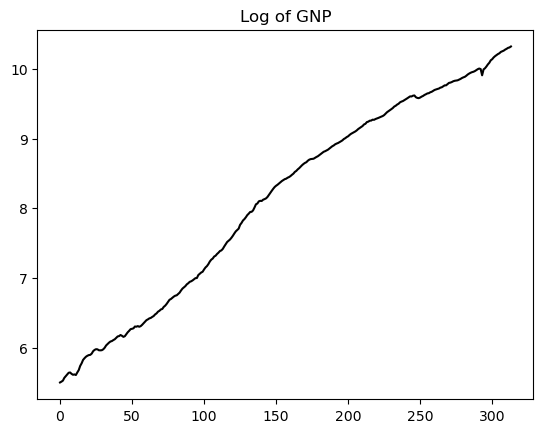

In [12]:
ylog = np.log(y)
plt.plot(ylog, color = 'black')
plt.title('Log of GNP')
plt.show()

Next we take differences and multiply by 100. 

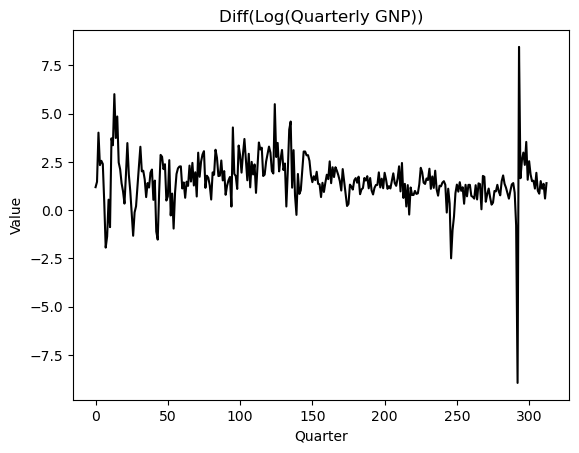

In [13]:
ylogdiff = (np.diff(np.log(y))) * 100
plt.plot(ylogdiff, color = 'black')
plt.title('Diff(Log(Quarterly GNP))')
plt.ylabel('Value')
plt.xlabel('Quarter')
plt.show()

Now let us fit AR(1) to this log-differenced data. 

In [14]:
armd_logdiff = AutoReg(ylogdiff, lags = 1).fit()
print(armd_logdiff.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  313
Model:                     AutoReg(1)   Log Likelihood                -512.052
Method:               Conditional MLE   S.D. of innovations              1.249
Date:                Fri, 07 Nov 2025   AIC                           1030.104
Time:                        15:11:31   BIC                           1041.333
Sample:                             1   HQIC                          1034.591
                                  313                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1596      0.110     10.519      0.000       0.943       1.376
y.L1           0.2487      0.055      4.536      0.000       0.141       0.356
                                    Roots           

This fitted AR(1) clearly has $|\hat{\phi}_1| < 1$ so it corresponds to a causal-stationary regime. 

### Causal Stationarity for AR($p$) with $p \geq 2$

When $p \geq 2$, causal-stationarity is determined by the roots of the AR polynomial $\phi(z) = 1 - \phi_1 z - \dots - \phi_p z^p$. Specifically, the AR($p$) is causal stationary if every root of the AR polynomial has modulus strictly larger than 1. 

For our first example, consider the AR(1) model that we fitted to the data $y_t = 100 \left(\log \text{GNP}_t - \log \text{GNP}_{t-1} \right)$. This model is: 
\begin{align*}
    y_t = 1.1596 + 0.2487 y_{t-1} + \epsilon_t. 
\end{align*}
This is AR(1) with $\phi_1$ coefficient 0.2487 which has magnitude strictly smaller than 1. So it is a causal stationary model. We can also rewrite this model as: 
\begin{align*}
   100 \left( \log \text{GNP}_t - \log \text{GNP}_{t-1}\right) = 1.1596 + 24.87 \left( \log \text{GNP}_{t-1} - \log \text{GNP}_{t-2} \right) + \epsilon_t. 
\end{align*}
If $G_t := 100 \log \text{GNP}_t$, then the above model in terms of $G_t$ becomes: 
\begin{align*}
    G_t - G_{t-1} = 1.1596 + 0.2487 \left(G_{t-1} - G_{t-2} \right) + \epsilon_t
\end{align*}
which is equivalen to
\begin{align*}
    G_t = 1.1596 + 1.2487 G_{t-1} - 0.2487 G_{t-2} + \epsilon_t. 
\end{align*}
This is an AR(2) model and we can ask whether this AR(2) model is causal stationary. For this, we need to calculate the roots of the AR(2) polynomial: 
\begin{align*}
   1 - 1.1487 z - 0.2487 z^2. 
\end{align*}
Its roots are given by
\begin{align*}
   \frac{1.1487 \pm \sqrt{1.1487^2 + 4 \times 0.2487}}{2 \times (-0.2487)}
\end{align*}
These can be computed in python as follows. 

In [17]:
coeffs = [-0.2487, -1.1487, 1]
roots = np.roots(coeffs) #these are roots of the quadratic
print(roots)
#The magnitudes of the roots are calculated as:
print(np.abs(roots))

[-5.3678854   0.74906754]
[5.3678854  0.74906754]


One of the roots has magnitude strictly larger than 1, while the other has magnitude strictly smaller than 1. Hence this AR(2) model is not causal-stationary. This makes sense because this AR(2) model is for $G_t = 100 \log \text{GNP}_t$ which is predominantly an increasing dataset. So we cannot expect a stationary model for this data. 

When we fit an AR($p$) model using AutoReg, the summary displays roots of the corresponding fitted AR polynomial along with their moduli. If all moduli are strictly larger than 1, then the model is causal stationary. 

Below we fit an AR($p$) model with $p \geq 2$ to the percent change (100 times differences of logs) GNP dataset. 

In [18]:
p = 2
armd_logdiff = AutoReg(ylogdiff, lags = p).fit()
print(armd_logdiff.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  313
Model:                     AutoReg(2)   Log Likelihood                -504.061
Method:               Conditional MLE   S.D. of innovations              1.224
Date:                Fri, 07 Nov 2025   AIC                           1016.123
Time:                        15:41:21   BIC                           1031.082
Sample:                             2   HQIC                          1022.102
                                  313                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9181      0.126      7.292      0.000       0.671       1.165
y.L1           0.1971      0.055      3.553      0.000       0.088       0.306
y.L2           0.2077      0.056      3.742      0.0

Note that the moduli are both strictly larger than 1, so this is a causal stationary AR model. Note that this model is for the percent changes of GNP (and not for GNP or log(GNP) directly). 

## How to determine the order of $p$ for AR(p)

Here is the method: Calculate PACF(h) for each $h = 1, 2, 3, \dots$. The PACF(h) is defined as the estimate of $\phi_h$ when the AR(h) model is fit to the observed time series data. In other words, PACF(1) is the estimate of $\phi_1$ when AR(1) is fit to the data, PACF(2) is the estimate of $\phi_2$ when AR(2) is fit to the data, and so on. If PACF(h) becomes negligible after a particular value of $h$ (say after $h = p$), then we use $p$ as the AR order. 

Here is the function for calculating the PACF. 

In [20]:
def sample_pacf(dt, p_max):
    pautocorr = []
    for p in range(1, p_max + 1):
        armd = AutoReg(dt, lags = p).fit()
        phi_p = armd.params[-1]
        pautocorr.append(phi_p)
    return pautocorr

Below we apply it to the percent change GNP dataset. 

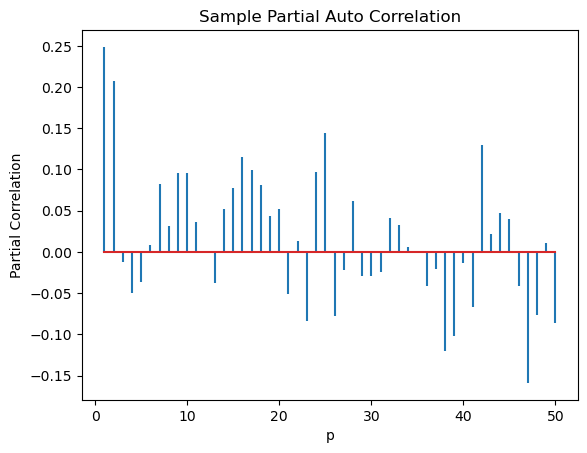

In [21]:
p_max = 50 
sample_pacf_vals = sample_pacf(ylogdiff, p_max)
markerline, stemline, baseline = plt.stem(range(1, p_max + 1), sample_pacf_vals)
markerline.set_marker("None")
plt.xlabel("p")
plt.ylabel('Partial Correlation')
plt.title("Sample Partial Auto Correlation")
plt.show()

From the plot above, we see that the PACF(h) values become somewhat negligible when $h = \geq 3$. Based on this, $p = 3$ is a reasonable choice for fitting AR($p$) to the percent change GNP data. 

Statsmodel has an inbuilt function for calculating PACF. Below, we compute this for the percent change GNP data, and check whether it gives the same values as our function. 

In [22]:
from statsmodels.tsa.stattools import pacf
pacf_values = pacf(ylogdiff, nlags=p_max, method = 'ols')
print(np.column_stack([sample_pacf_vals, pacf_values[1:]])) #check that these values match exactly 

[[ 0.24870755  0.24870755]
 [ 0.20772295  0.20772295]
 [-0.01181547 -0.01181547]
 [-0.05004494 -0.05004494]
 [-0.03595239 -0.03595239]
 [ 0.00802459  0.00802459]
 [ 0.08230295  0.08230295]
 [ 0.0316824   0.0316824 ]
 [ 0.09574666  0.09574666]
 [ 0.09594221  0.09594221]
 [ 0.03584216  0.03584216]
 [ 0.00112678  0.00112678]
 [-0.03725445 -0.03725445]
 [ 0.05155244  0.05155244]
 [ 0.07745691  0.07745691]
 [ 0.11526705  0.11526705]
 [ 0.09917843  0.09917843]
 [ 0.08106869  0.08106869]
 [ 0.04302832  0.04302832]
 [ 0.05237025  0.05237025]
 [-0.05067918 -0.05067918]
 [ 0.01267157  0.01267157]
 [-0.08404734 -0.08404734]
 [ 0.09698737  0.09698737]
 [ 0.14416186  0.14416186]
 [-0.07836845 -0.07836845]
 [-0.02209264 -0.02209264]
 [ 0.06157982  0.06157982]
 [-0.02871973 -0.02871973]
 [-0.02974936 -0.02974936]
 [-0.02387845 -0.02387845]
 [ 0.0406917   0.0406917 ]
 [ 0.03228025  0.03228025]
 [ 0.00545047  0.00545047]
 [ 0.00125922  0.00125922]
 [-0.0416868  -0.0416868 ]
 [-0.02112732 -0.02112732]
 

There is also an inbuilt function for plotting pacf values. This plot gives values for PACF($h$) for $h = 0, 1, 2, \dots$ with the default value for PACF($0$) = 1. 

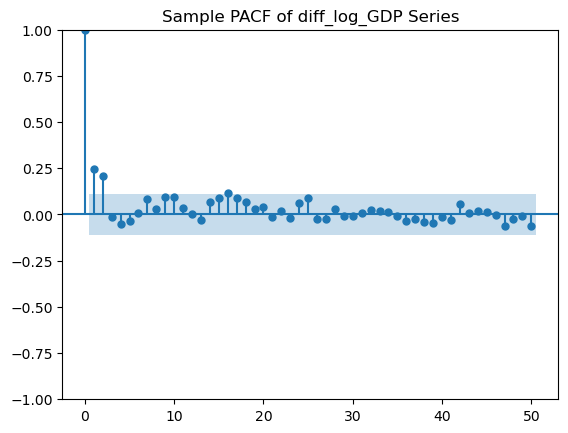

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots()
plot_pacf(ylogdiff, lags = p_max, ax = axes)
axes.set_title("Sample PACF of diff_log_GDP Series")
plt.show()

In comparison to our plot of the sample_pacf values, the inbuilt PACF plot from statsmodels will look slightly different (even though it is plotting the same values). The differences are: (a) it also plots the value 1 at lag 0, (b) it gives a shaded region that can be used to assess whether values are negligible or not.